In [1]:
import gzip
import numpy as np
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from bigdl.util.common import *
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.nn.layer import *
import pandas as pd
from pyspark import SparkContext
import datetime as dt

In [3]:
# Get the spark context
sc = SparkContext.getOrCreate(conf=create_spark_conf()
                              .setAppName("Spark Cluster with 3 cores")
                            .setMaster("spark://10.2.22.81:7077")
                            .set("spark.driver.memory","6g")
                            .set('spark.executor.cores', '3')
                            .set('spark.cores.max', '3')
                            .set('spark.executor.extraClassPath','/home/sunil1/Downloads/dist-spark-2.4.6-scala-2.11.8-all-0.13.0-dist/lib/bigdl-0.13.0-jar-with-dependencies.jar')
                            .set('spark.driver.extraClassPath','/home/sunil1/Downloads/dist-spark-2.4.6-scala-2.11.8-all-0.13.0-dist/lib/bigdl-0.13.0-jar-with-dependencies.jar')
                            .set("jars","/home/sunil1/Downloads/dist-spark-2.4.6-scala-2.11.8-all-0.13.0-dist/lib/bigdl-0.13.0-jar-with-dependencies.jar")
                           )
init_engine()

In [4]:
def download_mnist(path, kind='train'):
    print("Downloading the Fashion Mnist {} dataset...".format(kind), end='')
    images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/{}-images-idx3-ubyte.gz".format(kind)
    labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/{}-labels-idx1-ubyte.gz".format(kind)

    urllib.request.urlretrieve(images_url, os.path.join(path,"{}-images-idx3-ubyte.gz".format(kind)))
    urllib.request.urlretrieve(labels_url, os.path.join(path,"{}-labels-idx1-ubyte.gz".format(kind)))
    print("done.")

def load_mnist(path, kind='train'):

    labels_path = os.path.join(path,"{}-labels-idx1-ubyte.gz".format(kind) )
    images_path = os.path.join(path,"{}-images-idx3-ubyte.gz".format(kind) )

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return (images, labels)

In [5]:
path = "bigdl-data/fashion_mnist"
Path(path).mkdir(parents=True, exist_ok=True)
download_mnist(path)
download_mnist(path, kind='t10k')
train_images, train_labels = load_mnist(path)
test_images, test_labels = load_mnist(path, kind='t10k')

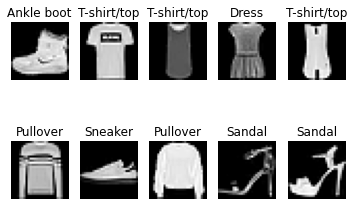

In [6]:
label_index = [ "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot" ]

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(np.column_stack(train_images[i].reshape(1, 28,28)),cmap="gray"); plt.axis("off")
    ax.set_title(label_index[train_labels[i]])


In [7]:
#Normalization
training_mean = np.mean(train_images)
training_std = np.std(train_images)
rdd_train_images = sc.parallelize(train_images)
rdd_train_labels = sc.parallelize(train_labels)
rdd_test_images = sc.parallelize(test_images)
rdd_test_labels = sc.parallelize(test_labels)

train_feats = np.array([(feat - training_mean) / training_std for feat in train_images])
rdd_train_sample = sc.parallelize([Sample.from_ndarray(feat, label+1) for feat, label in zip(train_feats, train_labels)])

test_feats = np.array([(feat - training_mean) / training_std for feat in test_images])
rdd_test_sample = sc.parallelize([Sample.from_ndarray(feat, label+1) for feat, label in zip(test_feats, test_labels)])

In [8]:
print("Number of training samples: {}".format(rdd_train_sample.count()))
print("Number of test samples: {}".format(rdd_test_sample.count()))

Number of training samples: 60000
Number of test samples: 10000


In [9]:
learning_rate = 0.4
training_epochs = 40
batch_size = 1026
display_step = 1

# Network Parameters
# 1st layer number of features
n_hidden_1 = 256 
# 2nd layer number of features
n_hidden_2 = 256
# MNIST data input (img shape: 28*28)
n_input = 784
# MNIST total classes (0-9 digits)
n_classes = 10 

In [10]:
from bigdl.nn.layer import *
model = Sequential() 
model.add(Reshape([1, 28, 28]))
model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))

model.add(Tanh())

model.add(SpatialAveragePooling(2, 2, 2, 2).set_name('pool1'))

#model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
model.add(Tanh())

model.add(SpatialConvolution(6, 12, 5, 5).set_name('conv2'))

model.add(SpatialAveragePooling(2, 2, 2, 2).set_name('pool2'))
#model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))

model.add(Reshape([12 * 4 * 4]))
model.add(Linear(12 * 4 * 4, 100).set_name('fc1'))
model.add(Tanh())

model.add(Linear(100, 10).set_name('score'))
model.add(LogSoftMax())
print(model)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialAveragePooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialAveragePooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax
Sequential[885ec0f3]{
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): Reshape[cd516d16](1x28x28)
  (2): SpatialConvolution[conv1](1 -> 6, 5 x 5, 1, 1, 0, 0)
  (3): Tanh[f5d8363d]
  (4): SpatialAveragePooling[pool1](2, 2, 2, 2, 0, 0)
  (5): Tanh[19b18d7e]
  (6): SpatialConvolution[conv2](6 -> 12, 5 x 5, 1, 1, 0, 0)
  (7): SpatialAveragePooling[pool2](2, 2, 2, 2, 0, 0)
  (8): Reshape[92df7a26](192)
  (9): Linear[fc1](192 -> 100)
  (10): Tanh[175e210d]
  (11): Linear[score](100 -> 10)
  (12): LogSoftMax[4c78d264]
}


In [11]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
import datetime as dt

# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=rdd_train_sample,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=rdd_test_sample,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy(),Loss()]
)

app_name='CNN_3_cores_with_Lenet5_arch-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(40))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
##t= "10"
##optimizer.set_checkpoint('/checkpoints',t,isOverWrite=True)

print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  CNN_2_cores_with_Lenet5_arch-20220522-214832


/tmp/spark-db8835db-141c-4134-b446-7b53b6e45f3b/userFiles-7280ed6a-6cfd-49dc-b295-35c833b46dac/bigdl-0.13.0-python-api.zip/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.


In [12]:
%%time
optimizer.optimize();

CPU times: user 22.7 ms, sys: 3.62 ms, total: 26.4 ms
Wall time: 3min 11s


In [14]:
loss_val2 = np.array(train_summary.read_scalar("Accuracy"))
loss_val = np.array(val_summary.read_scalar("Loss"))

print(len(loss_val2))

0


In [15]:
acc_training = np.array(val_summary.read_scalar("Top1Accuracy"))

In [16]:
print((acc_training[:,1]))

[0.70289999 0.74839997 0.79170001 0.82550001 0.83170003 0.83630002
 0.83240002 0.84960002 0.84609997 0.84829998 0.8538     0.85570002
 0.85750002 0.86150002 0.82800001 0.8653     0.86860001 0.86320001
 0.86809999 0.85610002 0.875      0.87690002 0.87879997 0.8786
 0.88       0.87949997 0.87370002 0.88429999 0.87440002 0.87879997
 0.88300002 0.88340002 0.88200003 0.88120002 0.88520002 0.88819999
 0.88459998 0.88679999 0.88630003 0.88620001]


Text(0.5, 1.0, 'Loss with spark in cluster mode with 3 cores')

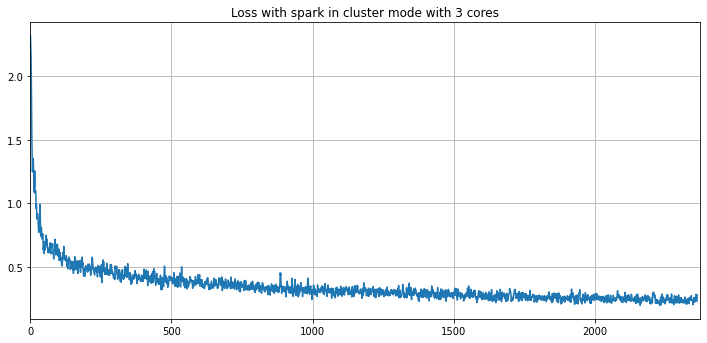

In [20]:
import matplotlib.pyplot as plt
loss_train = np.array(train_summary.read_scalar("Loss"))
acc_t = np.array(val_summary.read_scalar("Top1Accuracy"))

#loss = np.array(train_summary.read_scalar("Loss"))
#oss_train = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss_train[:,0],loss_train[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.grid(True)
plt.title("Loss with spark in cluster mode with 3 cores")

Text(0.5, 1.0, 'Accuracy with spark in cluster mode with 3 cores')

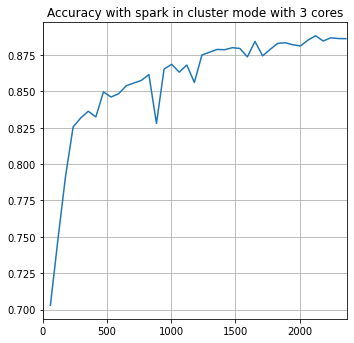

In [21]:
plt.figure(figsize = (12,12))
plt.subplot(2,2,2)
plt.plot(acc_t[:,0],acc_t[:,1],label='loss')
plt.xlim(0,loss_train.shape[0]+10)
plt.grid(True)
plt.title("Accuracy with spark in cluster mode with 3 cores")

In [19]:
accuracy_test =np.array(val_summary.read_scalar("Top1Accuracy"))
print(len(accuracy_test))

40
